In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.datasets import load_files
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk("C:\\Users\\caoho\\Desktop\\homework new\\biostat625\\final\\realwaste-main\\RealWaste"):
        print(dirname)
from sklearn.model_selection import train_test_split

C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Cardboard
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Food Organics
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Glass
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Metal
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Miscellaneous Trash
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Paper
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Plastic
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Textile Trash
C:\Users\caoho\Desktop\homework new\biostat625\final\realwaste-main\RealWaste\TEST\Vegetati

In [17]:
train_path = train_dir =  r"C:\Users\caoho\Desktop\homework new\biostat625\final\Output\TRAIN"
test_path = test_dir= r"C:\Users\caoho\Desktop\homework new\biostat625\final\Output\TEST"
def load_dataset(path):
    data = load_files(path) 
    files = np.array(data['filenames']) 
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels



In [4]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.utils import plot_model

from glob import glob

In [5]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|███████████████████████████████████████████████████████████████████████████████| 392/392 [00:03<00:00, 105.58it/s]


In [7]:
data.shape

(4278, 2)

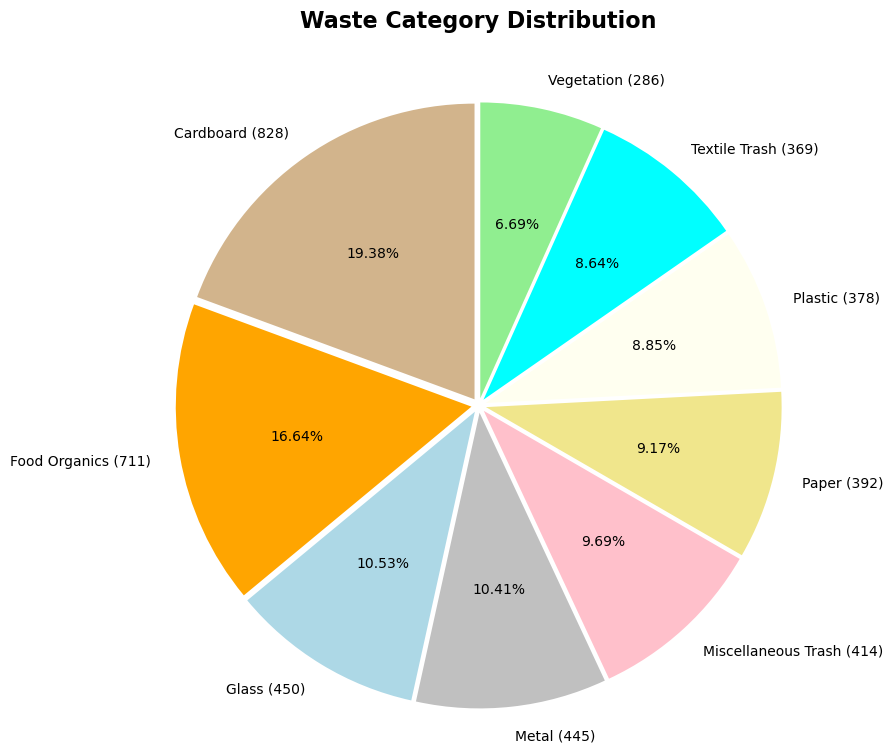

In [7]:
import matplotlib.pyplot as plt

counts = data.label.value_counts()
categories = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 
          'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
values = counts.values
labels = [f"{category} ({count})" for category, count in zip(categories, values)]
colors = ['tan', 'orange', 'lightblue', 'silver', 'pink', 
          'khaki', 'ivory', 'cyan', 'lightgreen']

plt.pie(values, labels=labels, colors=colors, 
        startangle=90, explode=[0.05] * len(labels), 
        autopct='%0.2f%%', radius=2)

plt.title('Waste Category Distribution', y=1.5, fontsize=16, weight='bold')

plt.show()




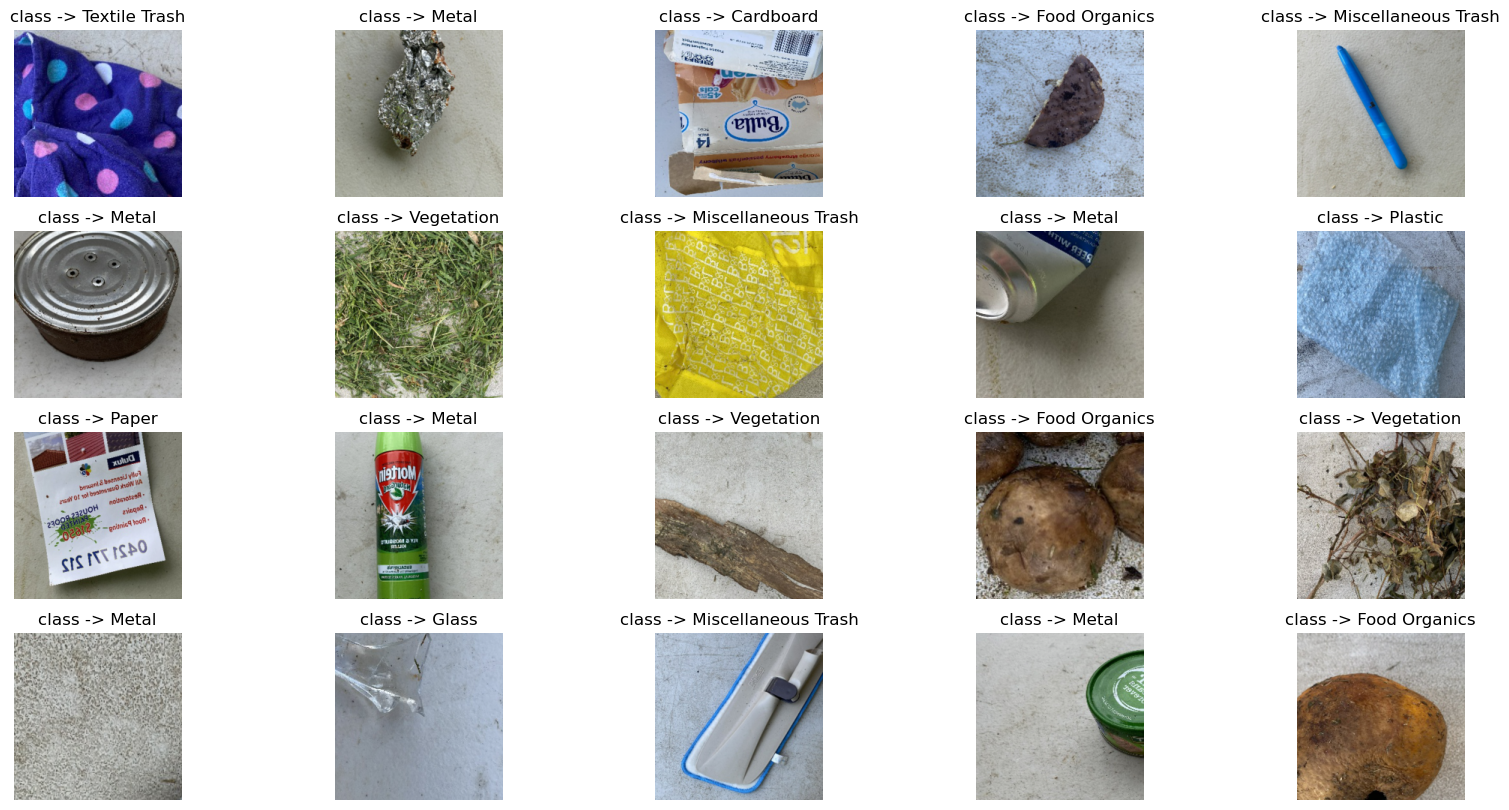

In [8]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)
class CustomDataset(Dataset):
    
    def __init__(self, root, transformations = None):
        
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
        
    def get_class(self, path): return os.path.dirname(path).split("\\")[-1]
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
    
    ds = CustomDataset(root = root, transformations = transformations)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "C:\\Users\\caoho\\Desktop\\homework new\\biostat625\\final\\RealWaste"
mean, std, random_im_size, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 224
tfs = T.Compose([T.RandomResizedCrop((random_im_size, random_im_size)), T.CenterCrop((im_size, im_size)), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"class -> {cls_names[int(gt)]}")
        
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

# CNN set up

In [9]:
from glob import glob 

className = glob(train_dir + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  9


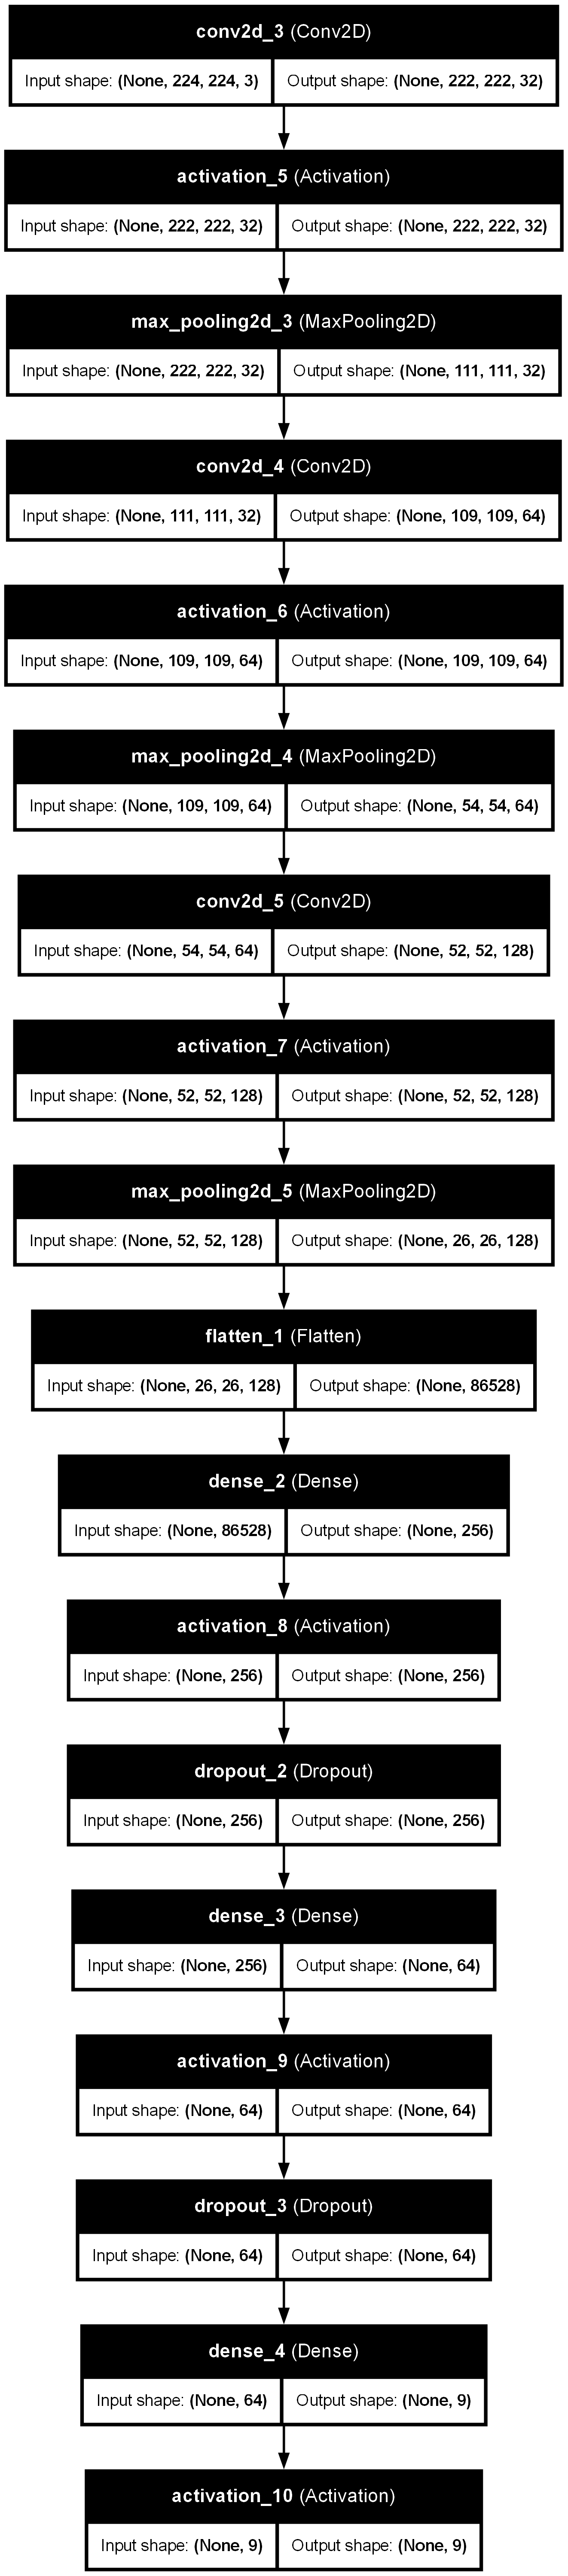

In [10]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(9))  
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
# Generate the plot
plot_model(model, to_file="cnn_model_plot.png", show_shapes=True, show_layer_names=True)


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.4))
#model.add(Dense(32))
#model.add(Activation("relu"))
#model.add(Dropout(0.4))
model.add(Dense(numberOfClass)) # output
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

batch_size = 128

In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,705 (84.92 MB)

 Trainable params: 22,261,705 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)


In [14]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)


In [15]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 4273 images belonging to 9 classes.
Found 479 images belonging to 9 classes.


In [16]:
hist = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator
)


Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1443 - loss: 2.4993 - val_accuracy: 0.2443 - val_loss: 2.0548
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.2203 - loss: 2.0790 - val_accuracy: 0.3424 - val_loss: 1.9600
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2784 - loss: 1.9531 - val_accuracy: 0.3549 - val_loss: 1.7866
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.3304 - loss: 1.8085 - val_accuracy: 0.3800 - val_loss: 1.6677
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3642 - loss: 1.7296 - val_accuracy: 0.4509 - val_loss: 1.5786
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3910 - loss: 1.6827 - val_accuracy: 0.4802 - val_loss: 1.4844
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.4333 - loss: 1.5505 - val_accuracy: 0.4134 - val_loss: 1.5489
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4403 - loss: 1.5690 - val_accuracy: 0.5073 - val_loss:

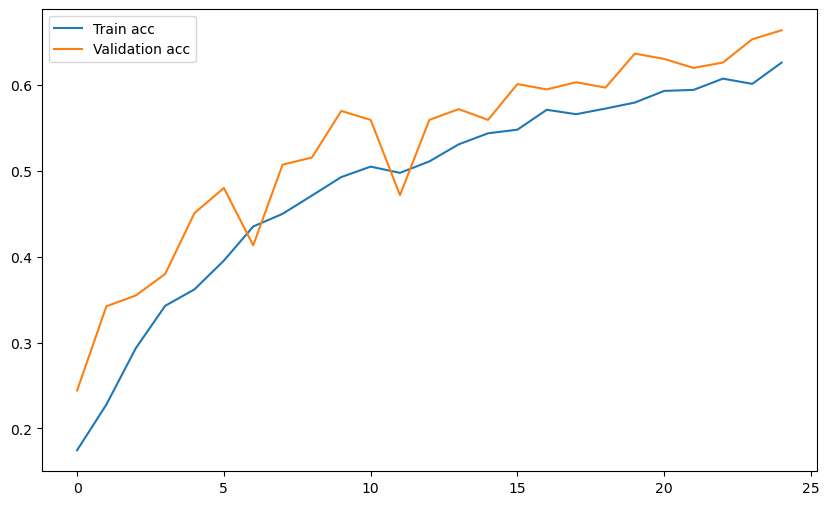

In [18]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label="Train acc")
plt.plot(hist.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.show()


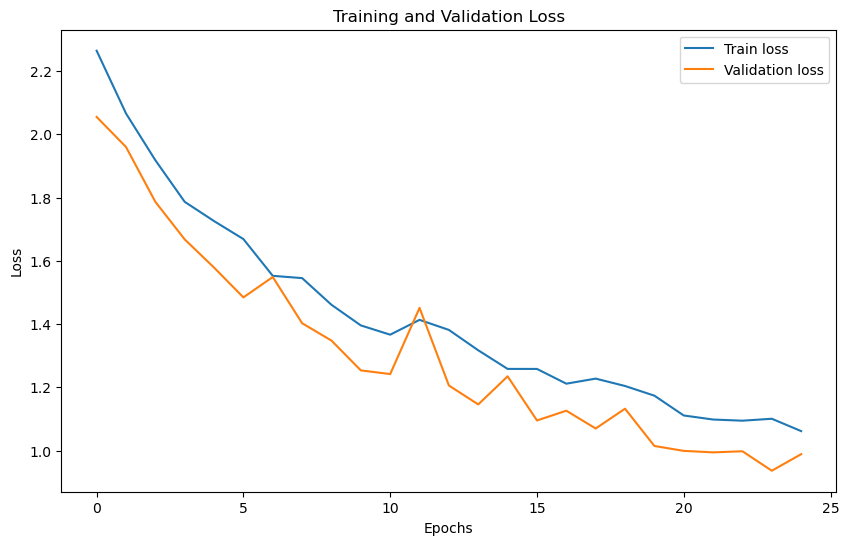

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=[10, 6])
plt.plot(hist.history["loss"], label="Train loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(9, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\caoho\Desktop\homework new\biostat625\final\Output\TRAIN",
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    r"C:\Users\caoho\Desktop\homework new\biostat625\final\Output\TEST",
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical"
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)




Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,564,873 (105.15 MB)

 Trainable params: 12,850,185 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 4273 images belonging to 9 classes.
Found 479 images belonging to 9 classes.
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.2275 - loss: 5.6183 - val_accuracy: 0.5532 - val_loss: 1.4269
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.4777 - loss: 1.4475 - val_accuracy: 0.5971 - val_loss: 1.2337
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.5519 - loss: 1.2792 - val_accuracy: 0.6576 - val_loss: 1.1187
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.5919 - loss: 1.1557 - val_accuracy: 0.6806 - val_loss: 0.9682
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.6247 - loss: 1.0635 - val_accuracy: 0.7140 - val_loss: 0.8837
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.6439 - loss: 0.9995 - val_accuracy: 0.7035 - val_loss: 0.8551
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.6775 - loss: 0.9201 - val_accuracy: 0.7056 - val_loss: 0.8473
Epoch 8/15
34/34 ━━━━━━━━━━━

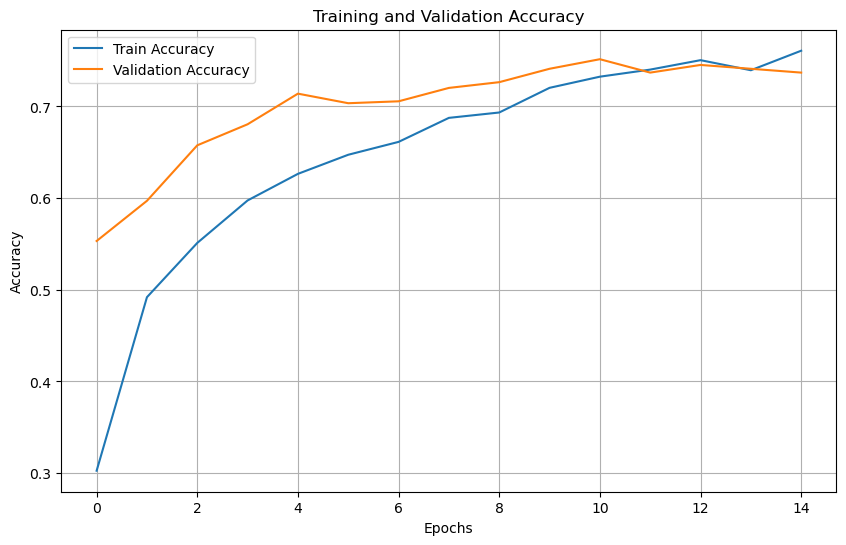

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


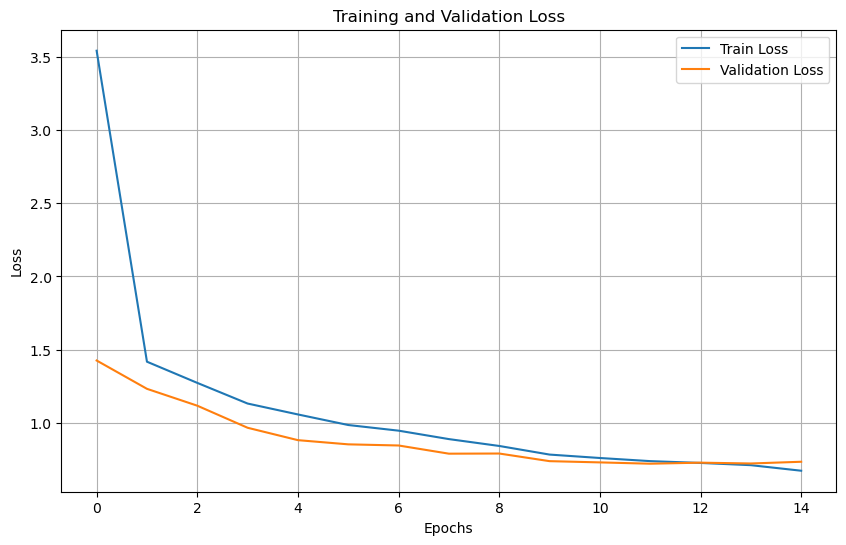

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [30]:
def predict_func(img):
   
    plt.figure(figsize=(6, 4))
    
    if img is None:
        print("\033[91m" + "Error: Image not found. Please check the file path." + "\033[0m")
        return
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = cv2.resize(img, (224, 224))
    
    img = np.reshape(img, [1, 224, 224, 3])
    
    result = np.argmax(model.predict(img))
    
   
    if result == 0:
        print("\033[94m" + "This image → Cardboard" + "\033[0m")
    elif result == 1:
        print("\033[94m" + "This image → Food Organics" + "\033[0m")
    elif result == 2:
        print("\033[94m" + "This image → Glass" + "\033[0m")
    elif result == 3:
        print("\033[94m" + "This image → Metal" + "\033[0m")
    elif result == 4:
        print("\033[94m" + "This image → Miscellaneous Trash" + "\033[0m")
    elif result == 5:
        print("\033[94m" + "This image → Paper" + "\033[0m")
    elif result == 6:
        print("\033[94m" + "This image → Plastic" + "\033[0m")
    elif result == 7:
        print("\033[94m" + "This image → Textile Trash" + "\033[0m")
    elif result == 8:
        print("\033[94m" + "This image → Vegetation" + "\033[0m")
    else:
        print("\033[91m" + "Unknown category" + "\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
This image → Paper


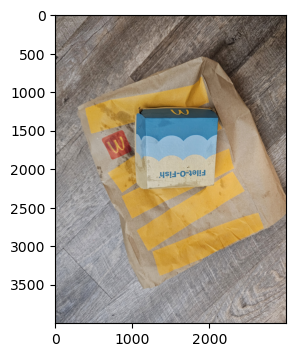

In [45]:
test_img1 = cv2.imread("C:\\Users\\caoho\\Desktop\\homework new\\biostat625\\final\\final project\\waste photo\\1.jpg")
predict_func(test_img1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image → Plastic


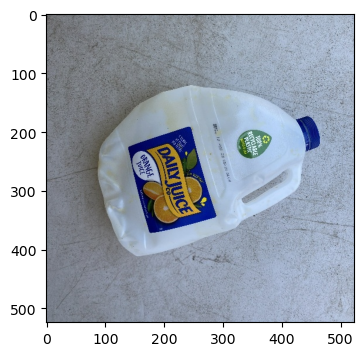

In [61]:
test_img2 = cv2.imread("C:\\Users\caoho\\Desktop\\homework new\\biostat625\\final\\RealWaste\\Plastic\\Plastic_299.jpg")
predict_func(test_img2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image → Metal


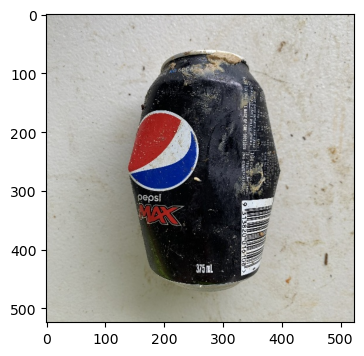

In [111]:
test_img3 = cv2.imread("C:\\Users\\caoho\\Desktop\\homework new\\biostat625\\final\\RealWaste\\Metal\\Metal_121.jpg")
predict_func(test_img3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image → Food Organics


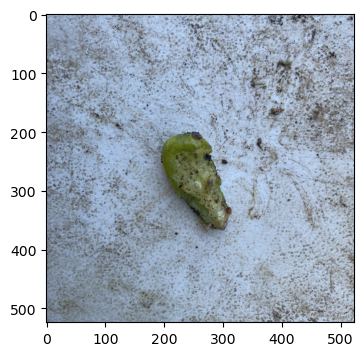

In [120]:
test_img4 = cv2.imread("C:\\Users\\caoho\\Desktop\\homework new\\biostat625\\final\\RealWaste\\Food Organics\\Food Organics_233.jpg")
predict_func(test_img4)